In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio
from scipy.io import wavfile

In [2]:
def generate_input(SNR):
    rate, s = wavfile.read('speech.wav')
    rate, b = wavfile.read('car_noise.wav')

    c = np.sqrt(np.sum(s**2) / np.sum(b**2))


    print(c)
    print(10**(-SNR/20))
    print(c * 10**(-SNR/20))
    y = s + c*b * 10**(-SNR/20)

    print(s[0])
    print(b[0])
    print(y[0])

    return y, rate


In [3]:
print(10**(-10/20))

0.31622776601683794


0.5018290568503218
0.31622776601683794
0.158692281570114
1
-229
-35.34053247955611


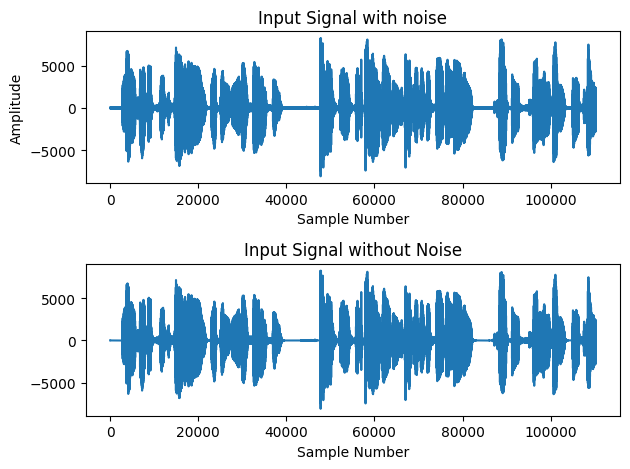

In [4]:

plt.subplot(2, 1, 1)
plt.plot(generate_input(10)[0])
plt.title('Input Signal with noise')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')


rate, s = wavfile.read('speech.wav')
plt.subplot(2, 1, 2)
plt.plot(s)
plt.title('Input Signal without Noise')
plt.xlabel('Sample Number')

plt.tight_layout()

In [5]:
Audio('speech.wav')

In [6]:
Audio('car_noise.wav')

In [7]:
y, rate = generate_input(10)
Audio(y, rate=rate)


0.5018290568503218
0.31622776601683794
0.158692281570114
1
-229
-35.34053247955611


1b - Estimating PSD

In [8]:
import numpy as np
from scipy.signal import get_window, stft

def estimate_STFT(x, N_fft=256, frameshift=64):
    """
    ESTIMATE_STFT Calculate the STFT of a signal.

    X = estimate_STFT(x) calculates the spectrum (STFT) 
    of a signal x.

    Parameters:
    x           -- Signal
    N_fft       -- FFT resolution (optional)
    frameshift  -- Number of samples between signal blocks (optional)

    Returns:
    X           -- STFT (STFT)
    """

    #Compute Hanning window with window length
    h_win = get_window('hann', N_fft)

    #Calculate STFT with window(h_win), overlap(N_fft-frameshift) and
    #FFT length(N_fft) 

    # spectrogram from scipy actually calculates the periodogram
    # and now we just want the STFT
    f, t, X = stft(x, window=h_win, noverlap=N_fft - frameshift, nfft=N_fft)

    return f, t, X


In [9]:
def estimate_PSD(x, N_fft=256, frameshift=64):
    _, _, stft = estimate_STFT(x, N_fft, frameshift)
    return np.square(np.abs(stft))


In [10]:
rate, b = wavfile.read('car_noise.wav')
y, _ = generate_input(-20)

Syy = estimate_PSD(y)
Sbb = estimate_PSD(b)

0.5018290568503218
10.0
5.018290568503217
1
-229
-1148.1885401872369


10.00780045351474


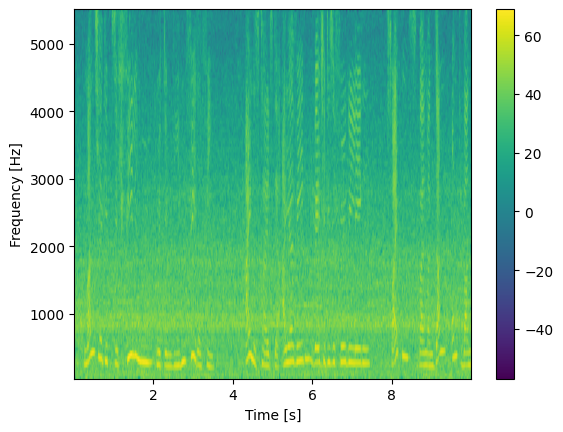

10.00780045351474


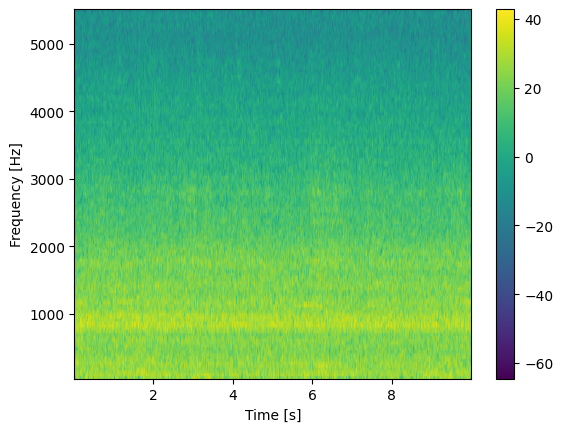

In [11]:
from plot_PSD import plot_PSD

plot_PSD(Syy, rate, N_fft=256, frameshift=64)
plot_PSD(Sbb, rate, N_fft=256, frameshift=64)

1c - wiener_filtering

In [12]:
def wiener_filtering(Y, Syy, Sbb, H_min):
    # H_min is given in db
    # convert to linear
    H_min_linear = 10**(-H_min/20)

    H_opt = np.maximum(1 - Sbb/Syy, H_min_linear)

    return H_opt * Y

1d = Applying filter

In [13]:

def calculate_output(S_hat, size_y, N_fft=256, frameshift=64):
    """
    CALCULATE_OUTPUT Calculate the output of the Wiener filter
    
    Parameters:
    S_hat       -- Spectrogram (complex-valued STFT output) of the Wiener filter
    size_y      -- Length of the original noisy signal (used to size the output)
    N_fft       -- FFT resolution (optional, default=256)
    frameshift  -- Hop size in samples between frames (optional, default=64)

    Returns:
    s_hat       -- Time-domain output of the Wiener filter
    """
    
    N_f, N_t = S_hat.shape

    # Initialize the output signal with zeros
    s_hat = np.zeros(size_y)


    # Convert each frame back to time domain and perform overlap-add
    for k in range(N_t):
        # Mirror and conjugate for real IFFT
        spectrum = np.concatenate([
            S_hat[:, k],
            np.conj(S_hat[-2:0:-1, k])
        ])

        # IFFT and scaling
        frame = np.real(np.fft.ifft(spectrum)) * frameshift / (N_fft / 2)

        # Overlap-add to the output signal
        start = k * frameshift
        end = start + N_fft

        if end <= size_y:
            s_hat[start:end] += frame
        elif start<=size_y:
            
            s_hat[start:size_y] += frame[:size_y - start]

    return s_hat

0.5018290568503218
3.1622776601683795
1.5869228157011401
1
-229
-362.4053247955611


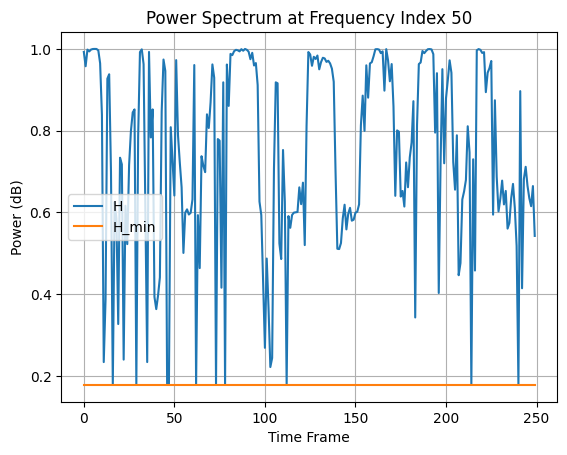

In [21]:
y = generate_input(-10)[0]
rate, b = wavfile.read('car_noise.wav')

Syy = estimate_PSD(y)
Sbb = estimate_PSD(b)

f, t, Y = estimate_STFT(y)

H_min_linear = 10**(-15/20)

H_opt = np.maximum(1 - Sbb/Syy, H_min_linear)

arb_freq = 50
# plt.plot(10 * np.log10(Syy[arb_freq][750:1000]), label='Syy')
# plt.plot(10 * np.log10(Sbb[arb_freq][750:1000] / 6), label='Sbb')
# plt.plot(1 - (Sbb/Syy)[50][750:1000], label='H')
plt.plot(H_opt[50][750:1000], label='H')
plt.plot(np.ones(250) * H_min_linear, label='H_min')
plt.ylabel('Power (dB)')
plt.xlabel('Time Frame')
plt.title(f'Power Spectrum at Frequency Index {arb_freq}')
plt.legend()
plt.grid()

In [32]:
def calculate_s_hat(attenuation, SNR):
    y = generate_input(SNR)[0]
    rate, b = wavfile.read('car_noise.wav')

    Syy = estimate_PSD(y)
    Sbb = estimate_PSD(b)

    f, t, Y = estimate_STFT(y)

    S_hat = wiener_filtering(Y, Syy, Sbb, attenuation)

    s_hat = calculate_output(S_hat, y.size)

    return s_hat



In [33]:
Audio(calculate_s_hat(5, -10), rate=rate)

In [34]:
Audio(calculate_s_hat(15, -10), rate=rate)

In [35]:
Audio(calculate_s_hat(50, -10), rate=rate)

e - estimating noise PSD

In [36]:
print(Syy.shape[1])

1724


In [37]:
def estimate_noise_PSD(Syy, beta, eps, K_over):
    Syy_smooth = np.zeros(Syy.shape)
    Sbb = np.zeros(Syy.shape)
    
    for i in range(Syy.shape[1]):
        if (i == 0):
            Syy_smooth[:, i] = Syy[:, i]
        else:
            Syy_smooth[:, i] = Syy_smooth[:, i-1]*beta + (1-beta)*Syy[:, i]

        if (i < 10):
            Sbb[:, i] = Syy[:, i]
        else:
            Sbb[:, i] = np.minimum(Sbb[:, i-1], Syy_smooth[:, i])*(1 + eps)

    return K_over * Sbb, Syy_smooth

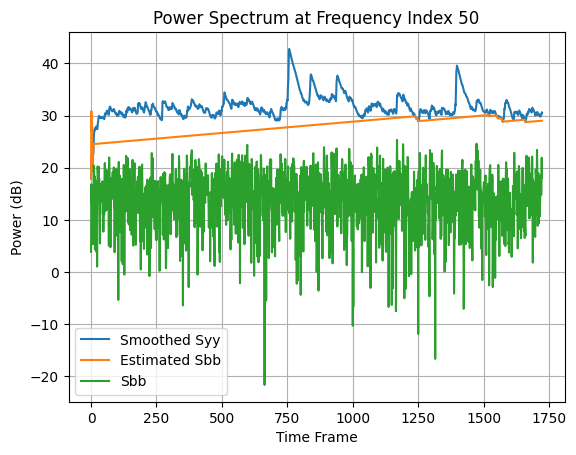

In [38]:
Syy = estimate_PSD(y)
Sbb_hat, Syy_smooth = estimate_noise_PSD(Syy, 0.95, 0.001, 6)
Sbb = estimate_PSD(b)

arb_freq = 50
plt.plot(10 * np.log10(Syy_smooth[arb_freq]), label='Smoothed Syy')
plt.plot(10 * np.log10(Sbb_hat[arb_freq] / 6), label='Estimated Sbb')
plt.plot(10 * np.log10(Sbb[arb_freq]), label='Sbb')
plt.ylabel('Power (dB)')
plt.xlabel('Time Frame')
plt.title(f'Power Spectrum at Frequency Index {arb_freq}')
plt.legend()
plt.grid()

com eps grande (0.1) Sbb vai acompanhar Syy e parecer muito com Syy (vai cortar sinais indesejados do speech), com eps menor, Sbb vai parecer mais com uma reta

In [44]:
def calculate_s_hat_with_unknown_noise(attenuation, SNR, K_over=6):
    y = generate_input(SNR)[0]

    Syy = estimate_PSD(y)
    Sbb_hat, Syy_smooth = estimate_noise_PSD(Syy, 0.95, 0.1, K_over)

    f, t, Y = estimate_STFT(y)
    
    S_hat = wiener_filtering(Y, Syy, Sbb_hat, attenuation)

    s_hat = calculate_output(S_hat, y.size)

    return s_hat


In [ ]:
Audio(calculate_s_hat_with_unknown_noise(5, -10), rate=rate)

In [41]:
Audio(calculate_s_hat_with_unknown_noise(15, -10), rate=rate)

In [49]:
Audio(calculate_s_hat_with_unknown_noise(15, -10, 6), rate=rate)

K_over = 6 parece reduzir bem o ruído
curiosamente K = 1 parece ser o melhor - reduz bem o ruido e não adiciona tanto ruido metalico